<a href="https://colab.research.google.com/github/Tuchsanai/AIMaster-seagate-training-2024/blob/main/Day2/transformer_pipeline/zero_shot_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Transformers installation
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


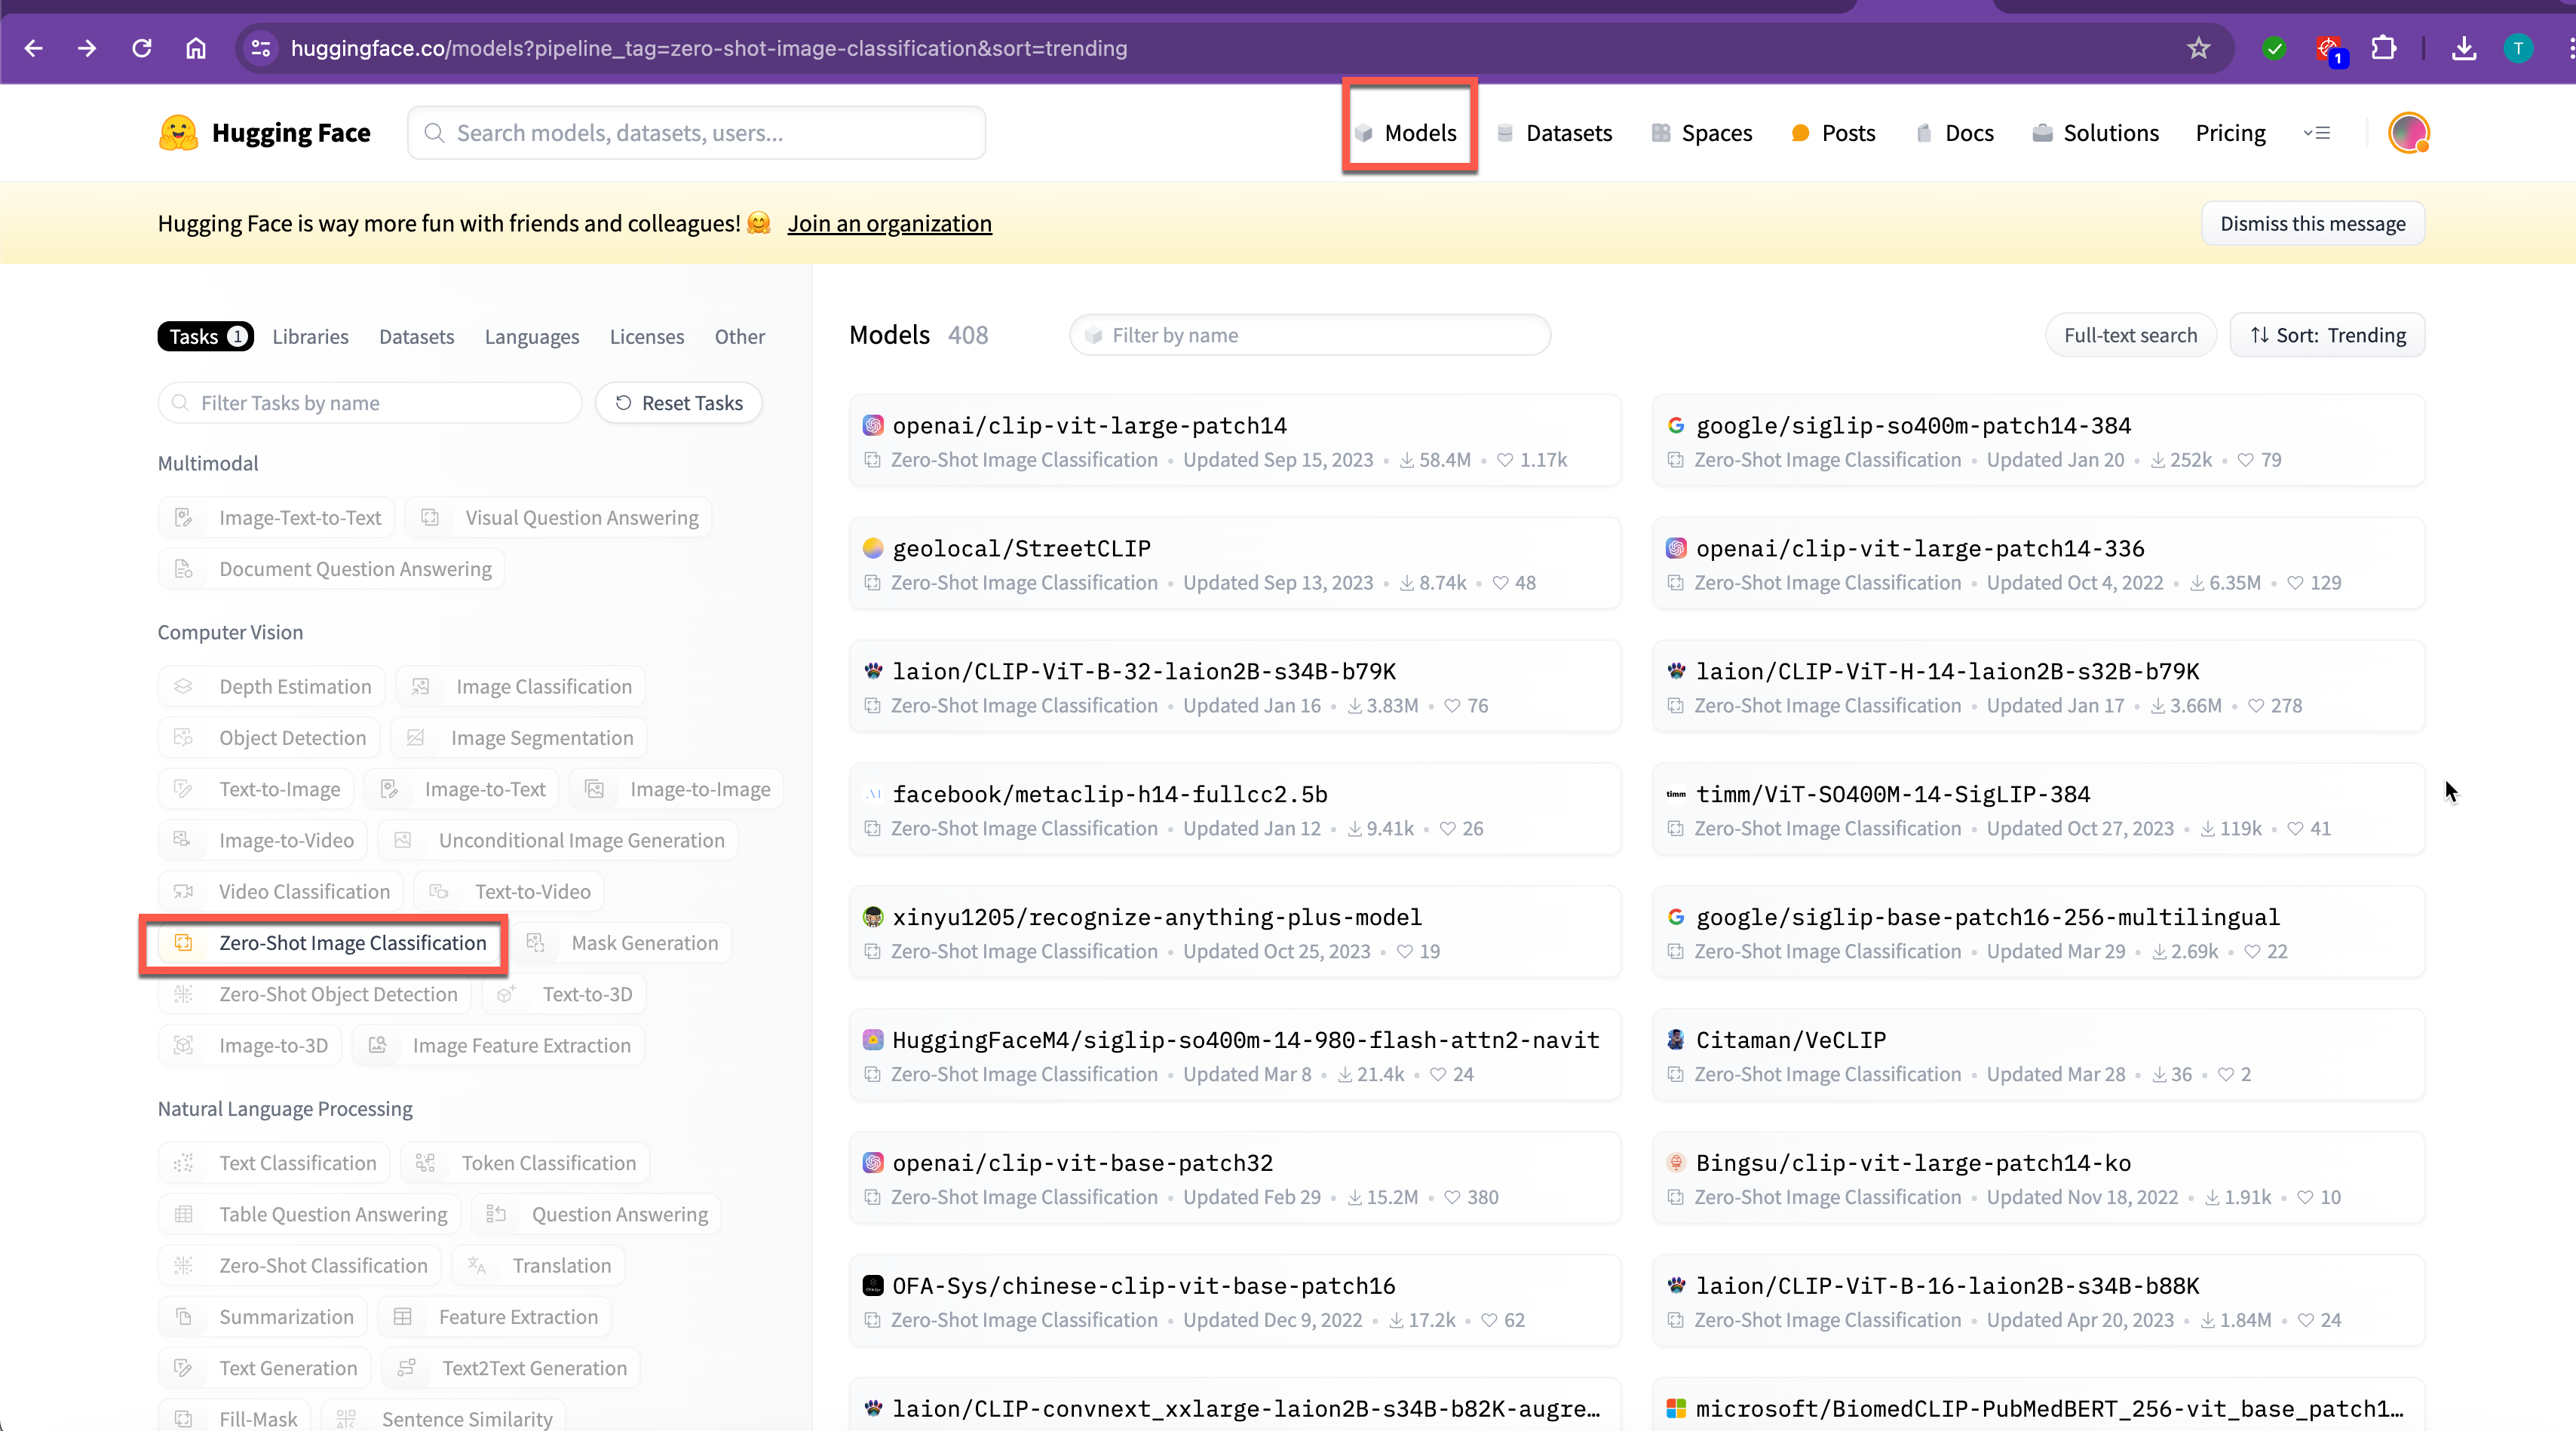

## Zero-shot image classification pipeline


https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=trending

The simplest way to try out inference with a model supporting zero-shot image classification is to use the corresponding [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline).
Instantiate a pipeline from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads):

In [8]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

detector

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Next, choose an image you'd like to classify.

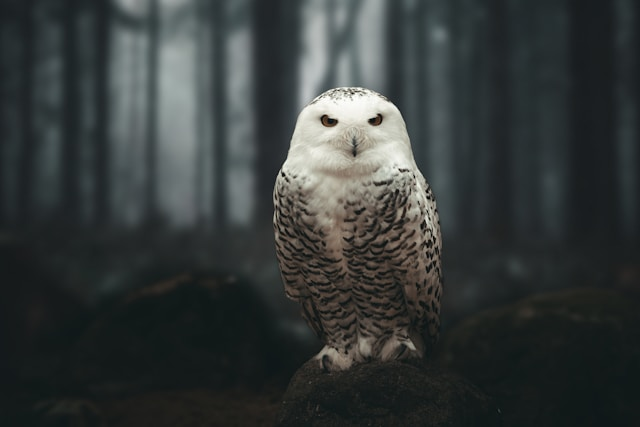

In [6]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

In [4]:
predictions = detector(image, candidate_labels=["fox", "bear", "seagull", "owl"])
predictions

[{'score': 0.9992450475692749, 'label': 'owl'},
 {'score': 0.0005944151198491454, 'label': 'seagull'},
 {'score': 8.649055234855041e-05, 'label': 'fox'},
 {'score': 7.409274985548109e-05, 'label': 'bear'}]

## Zero-shot image classification by hand

Now that you've seen how to use the zero-shot image classification pipeline, let's take a look how you can run zero-shot
image classification manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-image-classification&sort=downloads).
Here we'll use the same checkpoint as before:

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

checkpoint = "openai/clip-vit-large-patch14"
model      = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor  = AutoProcessor.from_pretrained(checkpoint)

Let's take a different image to switch things up.

In [ ]:
from PIL import Image
import requests

url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg" alt="Photo of a car"/>
</div>

Use the processor to prepare the inputs for the model. The processor combines an image processor that prepares the
image for the model by resizing and normalizing it, and a tokenizer that takes care of the text inputs.

In [ ]:
candidate_labels = ["tree", "car", "bike", "cat"]
inputs          = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

Pass the inputs through the model, and post-process the results:

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.998572, 'label': 'car'},
 {'score': 0.0010570387, 'label': 'bike'},
 {'score': 0.0003393686, 'label': 'tree'},
 {'score': 3.1572064e-05, 'label': 'cat'}]